In [11]:
####sample notebook.


import os
import sys
from pathlib import Path
import argparse

def setup_paths():
    """
   Dynamic path config
    """
    # Trova la directory radice del progetto
    project_root = Path.cwd()
    #project_root = Path(__file__).resolve().parent  # Modifica se necessario

    print(f"Project root is: {project_root}")
    # Percorso a "EEG-ANN-Pipeline"
    eeg_pipeline_path = project_root / "EEG-ANN-Pipeline"
    print(f"Oath to eeg-ann-pipeline': {eeg_pipeline_path}")
    default_input_dir= project_root.parent/ "data" / "rat_hippocampus"
    print(f"data_path: {default_input_dir}")
    # Percorso alla directory "contrastive_output" (output directory)
    default_output_dir = project_root / "contrastive_output"
    print(f"ouptut path: {default_output_dir}")

    # Aggiungi "EEG-ANN-Pipeline" al path
    if str(eeg_pipeline_path) not in sys.path:
        sys.path.append(str(eeg_pipeline_path))

    # Crea la directory di output se non esiste
    default_output_dir.mkdir(exist_ok=True)

    # Cambia la directory di lavoro alla radice del progetto
    os.chdir(project_root)

    # Ritorna i percorsi configurati
    return project_root, eeg_pipeline_path, default_output_dir, default_input_dir

project_root, eeg_pipeline_path, default_output_dir, default_input_dir = setup_paths()



Project root is: C:\Users\loren\Desktop\Usb32gb\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\Contrastive_Stuff
Oath to eeg-ann-pipeline': C:\Users\loren\Desktop\Usb32gb\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\Contrastive_Stuff\EEG-ANN-Pipeline
data_path: C:\Users\loren\Desktop\Usb32gb\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\data\rat_hippocampus
ouptut path: C:\Users\loren\Desktop\Usb32gb\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\Contrastive_Stuff\contrastive_output


In [22]:
# 
from some_functions import plot_embs
from data import LabelsDistance, TrialEEG, DatasetEEG, DatasetEEGTorch
from data.preprocessing import normalize_signals
from models import EncoderContrastiveWeights
from helpers.model_utils import plot_training_metrics, count_model_parameters, train_model
from helpers.visualization import plot_latent_trajectories_3d, plot_latents_3d
from layers.custom_layers import _Skip, Squeeze, _Norm, _MeanAndConv

# 
try:
    from torch.utils.data import DataLoader
    print("dataloader è stato importato correttamente!")
except ImportError:
    print("Errore: numpy non è stato importato!")
#from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import random
from torch import nn
import torch
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics
import joblib as jl

# 
from cebra import CEBRA
import cebra

# 
import matplotlib



# Random Seeds
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Configurazione GPU
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#print('torch_version is' f"{torch.version}")


dataloader è stato importato correttamente!


In [17]:
# functions to build the pipeline
def load_data(input_dir, name):
    input_dir = Path(input_dir).resolve()
    path =input_dir / f"{name}.jl"
    print(path)
    #path = os.path.join(input_dir, f"{name}.jl")
    try:
        data = jl.load(path)
        return data  # Return the loaded data if successful
    except FileNotFoundError as e:
        print(f"File Not Found Error: {e}")
        return None  # Return


# identify trials based upon behavioral data
def create_trial_ids(behav_data):

    trial_ids = np.ones(len(behav_data), dtype=int)
    c_t = [0]
    current_trial = 1

    for i in range(1, len(behav_data)):
        if behav_data[i] != behav_data[i - 1]:
            if behav_data[i - 1] == 0 and behav_data[i] == 1:
                current_trial += 1
                c_t.append(i)
                # include last index
    c_t.append(len(behav_data))
    return trial_ids, np.array(c_t)

  # Create overlapping windows from the dataset.
def create_windows(dataset, window, shift, chns):

    trials_new = []
    for trial in dataset.trials:
        signals = trial.eeg_signals[:chns, :]
        position_label = trial.eeg_signals[chns, :]
        direction_label = trial.eeg_signals[chns + 1, :]
        times = trial.timepoints

        ind_center = window // 2
        while ind_center + window // 2 < len(times):
            ind_min = ind_center - window // 2
            ind_max = ind_center + window // 2
            x = signals[:, ind_min:ind_max]
            label_full = {'Position': position_label[ind_max], 'Direction': int(
                direction_label[ind_max])}
            trials_new.append(TrialEEG(x, label_full, times[ind_min:ind_max]))
            ind_center += shift

    return DatasetEEG(trials_new, info=dataset.info)


# Build the model encoder.
def build_model(filters, dropout, latents, num_timepoints, chns, num_units=None, groups=1,normalize=True):
    """
    Build a cnn1d model with:
    - chns: Input channels.
    - filters: convolutional layer(s) filters.
    - latents: outpuit dimension (latent space).
    - num_timepoints: window dimension (test the optimal one).
    - dropout:  dropout.
    - num_units: optional intermediate filters.
    """
    if num_units is None:
        num_units = filters  # Se num_units non è specificato, usa filters.

    layers = [
        Squeeze(),
        nn.Conv1d(chns, filters, kernel_size=2),
        nn.GELU(),
        _Skip(nn.Conv1d(filters, filters, kernel_size=3), nn.GELU()),
        _Skip(nn.Conv1d(filters, filters, kernel_size=3), nn.GELU()),
        _Skip(nn.Conv1d(filters, filters, kernel_size=3), nn.GELU()),
        nn.Conv1d(filters, latents, kernel_size=3),
    ]

    if normalize:
        layers.append(_Norm())  #

    layers.extend([
        nn.Flatten(),  # 
        #nn.Dropout(dropout),  # 
    ])

    return nn.Sequential(*layers)
'''
SHALLOW NET
def build_model(filters, dropout, latents, num_timepoints, chns):
    
    return nn.Sequential(
        nn.Conv2d(1, filters, kernel_size=(1, num_timepoints)),
        nn.BatchNorm2d(filters),
        nn.Conv2d(filters, filters, kernel_size=(chns, 1), groups=filters),
        nn.BatchNorm2d(filters),
        nn.Dropout(dropout),
        nn.Flatten(),
        nn.Linear(filters, filters),
        nn.SELU(),
        nn.Dropout(dropout),
        nn.Linear(filters, latents)
    )

'''

def position_distance(l1, l2, sigma_pos):
    return torch.exp(- (l1 - l2)**2 / (2 * sigma_pos**2))


def time_distance(l1, l2, sigma_time):
    return torch.exp(-(l1 - l2)**2 / (2 * sigma_time**2))


def direction_distance(l1, l2):
    return (l1 == l2)

    # fig.savefig(Path(output_dir) / file_name)
# function for model evaluation


def generate_embeddings(model, dataset_pytorch, batch_size, device):
    model.eval()
    z, labels_position, labels_direction = [], [], []
    with torch.no_grad():
        for i in range(0, dataset_pytorch.num_trials, batch_size):
            x = dataset_pytorch.eeg_signals[i:i+batch_size].to(device)
            l_pos = dataset_pytorch.labels['Position'][i:i+batch_size]
            l_dir = dataset_pytorch.labels['Direction'][i:i+batch_size]

            f_x = model(x)

            z.append(f_x.cpu().numpy())
            labels_position.append(l_pos.cpu().numpy())
            labels_direction.append(l_dir.cpu().numpy())

    z = np.concatenate(z)
    labels_position = np.concatenate(labels_position)
    labels_direction_1 = np.concatenate(labels_direction)
    labels_direction_2 = 1 - labels_direction_1
    labels_ = np.stack((labels_position, labels_direction_1,
                       labels_direction_2), axis=1)
    return z, labels_

def decoding_knn(embedding_train, embedding_test, label_train, label_test,metric, n_n):
    #metric = 'cosine'
    #n_n = 25
    pos_decoder = KNeighborsRegressor(n_neighbors=n_n, metric=metric)
    dir_decoder = KNeighborsClassifier(n_neighbors=n_n, metric=metric)

    pos_decoder.fit(embedding_train, label_train[:, 0])
    dir_decoder.fit(embedding_train, label_train[:, 1])

    pos_pred = pos_decoder.predict(embedding_test)
    dir_pred = dir_decoder.predict(embedding_test)

    prediction = np.stack([pos_pred, dir_pred], axis=1)

    test_score = sklearn.metrics.r2_score(
    label_test[:, :2], prediction, multioutput='variance_weighted')
    max_label = np.max(label_test[:, 0])
    print(f'Max value of label_test[:, 0] is: {max_label}')
    
    pos_test_err_perc = np.median(abs(prediction[:, 0] - label_test[:, 0]) / max_label * 100)
    
    pos_test_err = np.median(abs(prediction[:, 0] - label_test[:, 0]))
    
    pos_test_score = sklearn.metrics.r2_score(
        label_test[:, 0], prediction[:, 0])

    return test_score, pos_test_err,pos_test_err_perc, pos_test_score






In [14]:
name='cicero'
data = load_data(default_input_dir, name)
chns=data['spikes'].shape[1]
#print(data['spikes'].shape)
#print(data['position'].shape)
print(chns)

C:\Users\loren\Desktop\Usb32gb\AI_PhD_Neuro_CNR\Empirics\GIT_stuff\AI_for_all\data\rat_hippocampus\cicero.jl
55


In [18]:
## create trials and prepare data
trial_ids, c_t = create_trial_ids(data['position'][:, 1])
  
## prepare data
### sampling rate
fs=40
valid_split=0.15
### sample sizes
ww=10
shift=1

spikes_and_label = np.concatenate((data['spikes'], data['position'][:, :2]), axis=1)
trials = [TrialEEG(spikes_and_label[c_t[i]:c_t[i+1]].T, 0, np.linspace(c_t[i] / fs, c_t[i+1] / fs, c_t[i+1] - c_t[i]))
              for i in range(len(c_t) - 1)]
dataset = DatasetEEG(trials)
dataset_training, dataset_validation = dataset.split_dataset(validation_size=valid_split)
### Create windowed datasets
dataset_windows_training = create_windows(dataset_training, ww, shift, chns=chns)
dataset_windows_validation = create_windows(dataset_validation, ww, shift, chns=chns)

### Convert to PyTorch datasets
dataset_pytorch = DatasetEEGTorch(dataset_windows_training)
dataset_validation_pytorch = DatasetEEGTorch(dataset_windows_validation)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_pytorch.to_device(device)
dataset_validation_pytorch.to_device(device)
print(device)

cuda


In [24]:
dataloader = DataLoader(dataset_pytorch, batch_size=512, shuffle=True)
dataloader_validation = DataLoader(dataset_validation_pytorch, batch_size=512, shuffle=False)


# Define label distances
labels_distance = LabelsDistance(labels_distance_functions={
        'Position': lambda l1, l2: position_distance(l1, l2, sigma_pos),
        'Direction': direction_distance,
    })
dropout=0.5
filters=32
latents=3
tau=0.5
l_rate=3e-4
epochs=500
sigma_pos=0.016
sigma_time=0.025
batch_size=512
### Build and train the model
#à# remove dropout in future vers
model = EncoderContrastiveWeights(
        layers=build_model(filters, dropout, latents, ww, chns),
        labels_distance=labels_distance,
        labels_weights=[1, 1],
        temperature=tau,
        train_temperature=True
    )
model.to(device)
print("Training dataset size:", len(dataset_training.trials))
print("Validation dataset size:", len(dataset_validation.trials))
print("Model architecture:", model)
print(f"Model has {count_model_parameters(model)} parameters.")
print(f"rat name is {name}")
print(f"{device}")

Training dataset size: 39
Validation dataset size: 7
Model architecture: EncoderContrastiveWeights(
  (layers): Sequential(
    (0): Squeeze()
    (1): Conv1d(55, 32, kernel_size=(2,), stride=(1,))
    (2): GELU(approximate='none')
    (3): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (4): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (5): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (6): Conv1d(32, 3, kernel_size=(3,), stride=(1,))
    (7): _Norm()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
)
Model has 13158 parameters.
rat name is cicero
cuda


In [25]:
# Train and evaluate the model
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)
metrics = train_model(model, optimizer, dataloader, epochs=epochs, dataloader_validation=dataloader_validation)
    # Save metrics and model
    #torch.save(model.state_dict(), f"{output_dir}/{name}_model.pth")
    #np.save(f"{output_dir}/{name}_metrics.npy", metrics)
    #plt.figure()

 # Evaluate the model and plot latent spaces
model.eval()

100%|██████████████████████████████████| 500/500 [18:16<00:00,  2.19s/it, alignement=-24.2, uniformity=25.6, loss=1.43]


EncoderContrastiveWeights(
  (layers): Sequential(
    (0): Squeeze()
    (1): Conv1d(55, 32, kernel_size=(2,), stride=(1,))
    (2): GELU(approximate='none')
    (3): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (4): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (5): _Skip(
      (module): Sequential(
        (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
        (1): GELU(approximate='none')
      )
    )
    (6): Conv1d(32, 3, kernel_size=(3,), stride=(1,))
    (7): _Norm()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
)

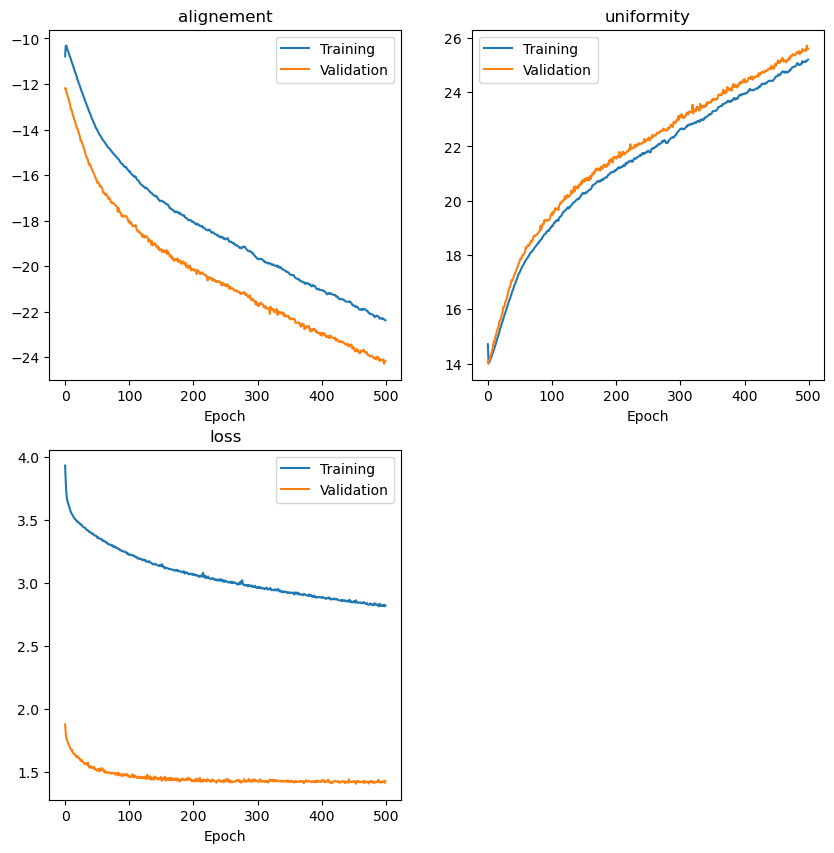

In [26]:
%matplotlib inline
plot_training_metrics(metrics)
#plt.show()

In [27]:
#model Eval.
# Generate embeddings for training data
z_train, labels_train = generate_embeddings(model, dataset_pytorch, batch_size, device)


# Generate embeddings for validation data
z_val, labels_val = generate_embeddings(model, dataset_validation_pytorch, batch_size, device)

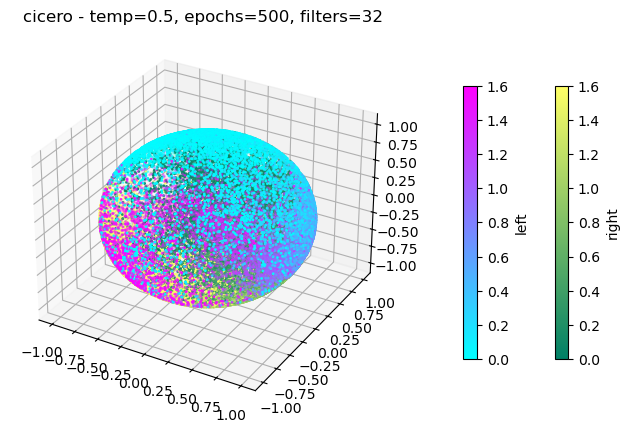

In [31]:
import ipywidgets as widgets
#plt.figure()
title_= f"{name} - temp={tau}, epochs={epochs}, filters={filters}"
plot_embs(z_train, labels_train,title_)
#plt.show()

In [30]:
### decoding 'a la cebra'
# given k and distance (usuall cosine)
# use knn regressor for position
# use knn classifier for direction 
# metric is cosine and n_neighbours free choice
metrica='cosine'
n_n=25
'''
returns a tuple:
- test_score (r2 score of predictions on labels (both position and direction): we have two predictions column for both position and
 direction and two true lables columns; R2 score is averaged and weighted by the variance of each output.
- pos_test_err: median prediction error on position absolute(predicton-true_postion)
- pos_test_score R2 score just on postion column 
'''
posdir_decode_CL = decoding_knn(z_train, z_val, labels_train, labels_val,metrica, n_n)
print('test_score is', posdir_decode_CL[0])
print('pos test error is', posdir_decode_CL[1])
print(f'pos test error - percent - is {posdir_decode_CL[2]:.2f}%')
print('pos test score is', posdir_decode_CL[3])
    
    

Max value of label_test[:, 0] is: 1.600000023841858
test_score is -0.039238677208359794
pos test error is 0.17653701196832117
pos test error - percent - is 11.03%
pos test score is 0.16711859981103794
